In [29]:
import pandas as pd
import zipfile
import io
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import nlpaug.augmenter.word as naw
import numpy as np
import transformers
from tqdm import tqdm
import torch
import re
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

In [ ]:
!pip install nlpaug transformers torch

Creating data frame

In [4]:
data_path = '/content/'
file_names = [
    'Sentences_50Agree.txt',
    'Sentences_66Agree.txt',
    'Sentences_75Agree.txt',
    'Sentences_AllAgree.txt'
]

dataset = []

for file_name in file_names:
    full_path = os.path.join(data_path, file_name)

    category_name = file_name.replace('.txt', '')

    print(f"Processing {file_name}...")

    if os.path.exists(full_path):
        # We use 'latin-1' to avoid the UnicodeDecodeError
        with open(full_path, 'r', encoding='latin-1') as f:
            for line in f:
                line = line.strip()

                # Skip empty lines
                if not line:
                    continue

                # This ensures that if the sentence itself contains an '@',
                # we still split correctly at the label.
                parts = line.rsplit('@', 1)

                if len(parts) == 2:
                    sentence_text = parts[0].strip()
                    label_text = parts[1].strip()

                    dataset.append({
                        'category': category_name,
                        'sentence': sentence_text,
                        'label': label_text
                    })
                else:
                    # This handles lines that don't match the format (like headers)
                    print(f"Skipping malformed line in {file_name}: {line[:50]}...")
    else:
        print(f"File not found: {full_path}")

# 4. Create DataFrame
df = pd.DataFrame(dataset)

# --- Display Results ---
print("\nSuccess!")
print(f"Total rows: {len(df)}")
print("\nFirst 5 rows:")
print(df.head())

print("\nLast 5 rows:")
print(df.tail())


Processing Sentences_50Agree.txt...
Processing Sentences_66Agree.txt...
Processing Sentences_75Agree.txt...
Processing Sentences_AllAgree.txt...

Success!
Total rows: 14780

First 5 rows:
            category                                           sentence  \
0  Sentences_50Agree  According to Gran , the company has no plans t...   
1  Sentences_50Agree  Technopolis plans to develop in stages an area...   
2  Sentences_50Agree  The international electronic industry company ...   
3  Sentences_50Agree  With the new production plant the company woul...   
4  Sentences_50Agree  According to the company 's updated strategy f...   

      label  
0   neutral  
1   neutral  
2  negative  
3  positive  
4  positive  

Last 5 rows:
                 category                                           sentence  \
14775  Sentences_AllAgree  Operating result for the 12-month period decre...   
14776  Sentences_AllAgree  HELSINKI Thomson Financial - Shares in Cargote...   
14777  Sentences_AllAgr

Plot distribution of each label

/tmp/ipython-input-1963795901.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=df, palette='viridis')


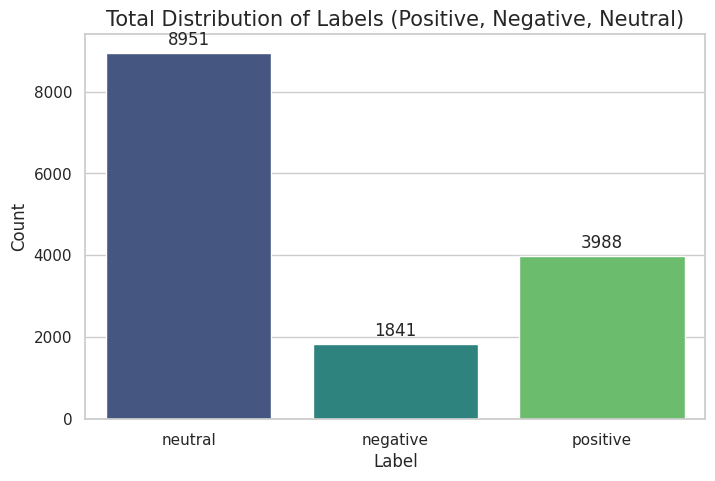

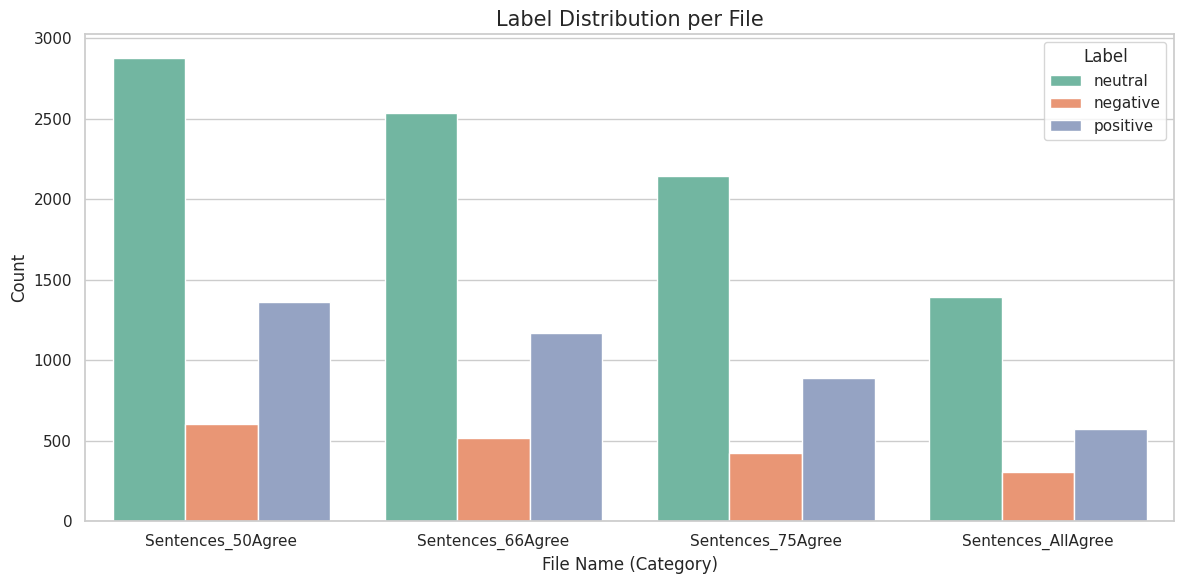

In [5]:
# 1. Set the visual style
sns.set_theme(style="whitegrid")

# --- PLOT 1: Total Distribution of Labels ---
plt.figure(figsize=(8, 5)) # Set the size of the graph

# Create the count plot
ax = sns.countplot(x='label', data=df, palette='viridis')

# Add title and labels
plt.title('Total Distribution of Labels (Positive, Negative, Neutral)', fontsize=15)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add the actual numbers on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.show()


# --- PLOT 2: Distribution of Labels per File (Category) ---
plt.figure(figsize=(12, 6))

# We use 'hue' to split the bars by category
sns.countplot(x='category', hue='label', data=df, palette='Set2')

plt.title('Label Distribution per File', fontsize=15)
plt.xlabel('File Name (Category)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Label')

plt.tight_layout() # Adjust layout to prevent clipping
plt.show()


Contextual Word Embedding Augmentation

Loading BERT model (Contextual Augmentation)...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

The following layers were not sharded: bert.encoder.layer.*.attention.output.dense.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.token_type_embeddings.weight, cls.predictions.transform.dense.weight, cls.predictions.decoder.bias, bert.encoder.layer.*.attention.self.query.bias, cls.predictions.transform.LayerNorm.weight, bert.encoder.layer.*.output.dense.weight, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.intermediate.dense.bias, cls.predictions.transform.LayerNorm.bias, bert.encoder.layer.*.

Loading weights:   0%|          | 0/202 [00:00<?, ?it/s]


Target rows per class: 8951
------------------------------
Augmenting 'negative': Generating 7110 new sentences...


100%|██████████| 7110/7110 [09:54<00:00, 11.96it/s]


Augmenting 'positive': Generating 4963 new sentences...


100%|██████████| 4963/4963 [06:50<00:00, 12.10it/s]
/tmp/ipython-input-3639300788.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df_balanced, palette='viridis')




--- Balancing Complete ---
label
neutral     8951
negative    8951
positive    8951
Name: count, dtype: int64


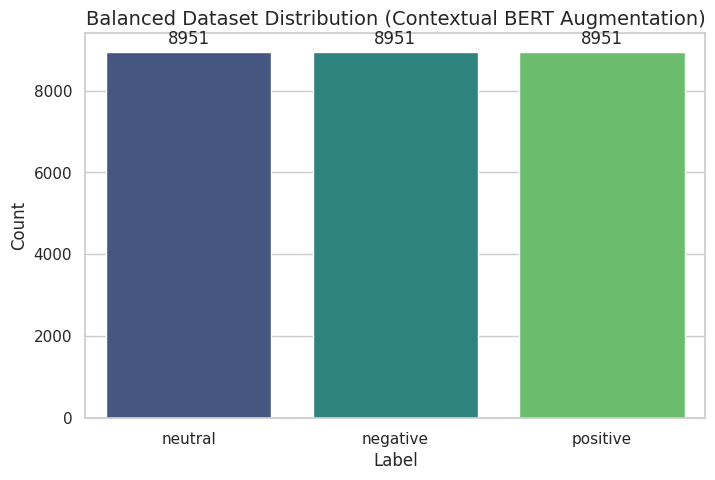


Examples of Generated Data:
          label                                           sentence
10792  negative  pacific international electronic industry cong...
10793  negative  in tinyurl link takes one to a scamming platfo...
10794  negative  although unlike the best 50 index, which rose ...
10795  negative  compared after the ftse 1000 index, and rose 9...
10796  negative  one of the challenges in the oil field around ...


In [10]:


# --- 1. THE FIX for "AttributeError: _convert_token_to_id" ---
# This line makes nlpaug compatible with the new transformers version
transformers.models.bert.tokenization_bert.BertTokenizer._convert_token_to_id = \
    lambda self, token: self.convert_tokens_to_ids(token)
# -------------------------------------------------------------

# 2. Initialize the BERT Augmenter
# We use 'bert-base-uncased' which understands English context very well.
print("Loading BERT model (Contextual Augmentation)...")
aug = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased',
    action="substitute",
    device='cuda' if torch.cuda.is_available() else 'cpu' # Use GPU if available
)

# 3. Analyze current data to find the target count
label_counts = df['label'].value_counts()
max_count = label_counts.max()

print(f"\nTarget rows per class: {max_count}")
print("-" * 30)

# 4. Create the Balanced Dataset
balanced_data = []

for label in df['label'].unique():
    # Get existing data for this label
    class_subset = df[df['label'] == label]
    existing_sentences = class_subset['sentence'].tolist()

    # Get the category reference (use the first one found)
    category_ref = class_subset['category'].iloc[0]

    # Add ALL existing original sentences first
    for sent in existing_sentences:
        balanced_data.append({
            'sentence': sent,
            'label': label,
            'category': category_ref
        })

    # Calculate how many artificial sentences we need
    needed = max_count - len(existing_sentences)

    if needed > 0:
        print(f"Augmenting '{label}': Generating {needed} new sentences...")

        # We use a progress bar to track generation
        with tqdm(total=needed) as pbar:
            generated = 0
            i = 0
            while generated < needed:
                # Cycle through existing sentences to create variations
                original_sent = existing_sentences[i % len(existing_sentences)]

                try:
                    # Generate Augmented Sentence
                    augmented_text = aug.augment(original_sent)

                    # Convert list to string if necessary
                    if isinstance(augmented_text, list):
                        augmented_text = augmented_text[0]

                    # Store the new data
                    balanced_data.append({
                        'sentence': augmented_text,
                        'label': label,
                        'category': 'Augmented_Data' # Mark as synthetic
                    })

                    generated += 1
                    pbar.update(1)

                except Exception as e:
                    # Sometimes very short sentences fail, just skip to next
                    pass

                i += 1

# 5. Convert list back to DataFrame
df_balanced = pd.DataFrame(balanced_data)

print("\n\n--- Balancing Complete ---")
print(df_balanced['label'].value_counts())

# --- 6. PLOT THE RESULTS ---
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df_balanced, palette='viridis')
plt.title('Balanced Dataset Distribution (Contextual BERT Augmentation)', fontsize=14)
plt.ylabel('Count')
plt.xlabel('Label')

# Add count labels on top of bars
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.show()

# Show a few examples of the new synthetic data
print("\nExamples of Generated Data:")
print(df_balanced[df_balanced['category'] == 'Augmented_Data'][['label', 'sentence']].head(5))


In [11]:
# Save to CSV
df_balanced.to_csv('balanced_dataset.csv', index=False, encoding='utf-8')

print("Dataset saved successfully as 'balanced_dataset.csv'")

Dataset saved successfully as 'balanced_dataset.csv'


Loading new dataset

In [19]:

def load_and_clean_data(file_path):
    """
    Loads a CSV file, prints class distribution and data preview,
    and removes missing values.

    Args:
        file_path (str): The location of the CSV file.

    Returns:
        pd.DataFrame: The loaded and cleaned DataFrame, or None if the file was not found.
    """
    df_loaded = None

    try:
        df_loaded = pd.read_csv(file_path)
        print(f"Successfully loaded {len(df_loaded)} rows from {file_path}")

        # --- Class Distribution Check ---
        print("\n--- Class Distribution Check ---")
        if 'label' in df_loaded.columns:
            print(df_loaded['label'].value_counts())
        else:
            print("Warning: 'label' column not found. Skipping class distribution check.")

        # --- Data Preview ---
        print("\n--- Data Preview (First 5 rows) ---")
        print(df_loaded.head())

        # --- Cleaning Missing Values ---
        if df_loaded.isnull().values.any():
            print("\nWarning: Found missing values. Cleaning now...")
            df_loaded = df_loaded.dropna()
            print(f"Data cleaned. New row count: {len(df_loaded)}")
        else:
            print("\nNo missing values found. Data is clean.")

        return df_loaded

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please check the filename.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

Successfully loaded 26853 rows from /content/balanced_dataset.csv

--- Class Distribution Check ---
label
neutral     8951
negative    8951
positive    8951
Name: count, dtype: int64

--- Data Preview (First 5 rows) ---
                                            sentence    label  \
0  According to Gran , the company has no plans t...  neutral   
1  Technopolis plans to develop in stages an area...  neutral   
2  At the request of Finnish media company Alma M...  neutral   
3  In Sweden , Gallerix accumulated SEK denominat...  neutral   
4  The company supports its global customers in d...  neutral   

            category  
0  Sentences_50Agree  
1  Sentences_50Agree  
2  Sentences_50Agree  
3  Sentences_50Agree  
4  Sentences_50Agree  

No missing values found. Data is clean.


Pre process

In [ ]:
path = '/content/balanced_dataset.csv'
df = load_and_clean_data(path)

In [21]:


# Optional: Map common contractions (textspeak) to full words
# BERT understands "won't", but explicit text is often cleaner.
CONTRACTIONS = {
    "won't": "will not",
    "can't": "cannot",
    "n't": " not",
    "'re": " are",
    "'s": " is",
    "'d": " would",
    "'ll": " will",
    "'t": " not",
    "'ve": " have",
    "'m": " am"
}

def preprocess_text(text):
    text = str(text)

    # --- 1. NORMALIZATION START ---

    # A. Fix "Smart Quotes" and Windows encoding artifacts
    # Because you read files as 'latin-1', you might have curly quotes like ’ instead of '
    text = text.replace("’", "'").replace("‘", "'").replace("“", '"').replace("”", '"')

    # B. Lowercase (Essential for BERT uncased)
    text = text.lower()

    # C. Expand Contractions (Optional but recommended)
    for contraction, expansion in CONTRACTIONS.items():
        text = text.replace(contraction, expansion)

    # --- NORMALIZATION END ---

    # --- 2. CLEANING (From previous step) ---

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove User Mentions (@)
    text = re.sub(r'\@\w+', '', text)

    # Remove HTML
    text = re.sub(r'<.*?>', '', text)

    # Remove Numbers? -> NO.
    # In finance, "3.5%" vs "500" is a huge difference. Keep numbers.

    # Remove Non-ASCII characters (Optional)
    # This removes emojis or weird symbols, keeping only English letters/numbers/punctuation
    # If your data is strictly English, this is safe.
    text = re.sub(r'[^\x00-\x7f]', r'', text)

    # Clean whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# --- Apply ---
print("Applying Normalization and Cleaning...")
df['sentence'] = df['sentence'].apply(preprocess_text)
print("Done.")


Applying Normalization and Cleaning...
Done.


In [22]:
# Save to CSV
df.to_csv('balanced_normalized_dataset.csv', index=False, encoding='utf-8')

print("Dataset saved successfully as 'balanced_dataset.csv'")

Dataset saved successfully as 'balanced_dataset.csv'


Split dataset into train and validation

In [ ]:
path = '/content/balanced_normalized_dataset.csv'
df = load_and_clean_data(path)

In [24]:

# 1. Split the data
# test_size=0.20  ->  20% for validation
# random_state=42 ->  Ensures the "random" shuffle is reproducible (same result every time you run it)
# shuffle=True    ->  Mixes the data thoroughly before splitting
# stratify=...    ->  Ensures both Train and Val have the exact same proportion of labels
train_df, val_df = train_test_split(
    df,
    test_size=0.20,
    random_state=42,
    shuffle=True,
    stratify=df['label']
)

# 2. Print the results to verify
print(f"Total Rows: {len(df)}")
print(f"Training Rows (80%): {len(train_df)}")
print(f"Validation Rows (20%): {len(val_df)}")

print("\n--- Training Set Distribution ---")
print(train_df['label'].value_counts())

print("\n--- Validation Set Distribution ---")
print(val_df['label'].value_counts())

train_df.to_csv('train_dataset.csv', index=False)
val_df.to_csv('val_dataset.csv', index=False)
print("\nFiles 'train_dataset.csv' and 'val_dataset.csv' have been saved.")


Total Rows: 26853
Training Rows (80%): 21482
Validation Rows (20%): 5371

--- Training Set Distribution ---
label
neutral     7161
negative    7161
positive    7160
Name: count, dtype: int64

--- Validation Set Distribution ---
label
positive    1791
neutral     1790
negative    1790
Name: count, dtype: int64

Files 'train_dataset.csv' and 'val_dataset.csv' have been saved.


Dataset class, Dataloader, Tokenizer

In [26]:

# 1. Load the Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 2. Measure the length of every sentence
token_lens = []

print("Calculating token lengths...")

# We iterate over every sentence in the dataframe
for txt in df['sentence']:
    # encode_plus handles the tokenization and adds special tokens [CLS], [SEP]
    tokens = tokenizer.encode(str(txt), max_length=512, truncation=True)
    token_lens.append(len(tokens))

# 3. Print Statistics
max_length = max(token_lens)

print(f"\n--- Results ---")
print(f"Maximum Token Length: {max_length}")



Calculating token lengths...

--- Results ---
Maximum Token Length: 150


In [ ]:
path = '/content/train_dataset.csv'
train_dataset = load_and_clean_data(path)

path = '/content/val_dataset.csv'
val_dataset = load_and_clean_data(path)

In [28]:

# Load Tokenizer (FinBERT)
MODEL_NAME = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class FinancialDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'sentence_text': text,
            # We still need .flatten() because it returns shape (1, max_len)
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long)
        }

# --- Re-setup DataLoaders with the fixed class ---

MAX_LEN = 155
BATCH_SIZE = 16
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}

def get_data_loaders(df, tokenizer, max_len, batch_size):
    df = df.copy()
    df['label_id'] = df['label'].map(label_map)

    ds = FinancialDataset(
        texts=df.sentence.to_numpy(),
        labels=df.label_id.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2,
        shuffle=True
    )

# Re-create loaders
train_data_loader = get_data_loaders(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = get_data_loaders(val_df, tokenizer, MAX_LEN, BATCH_SIZE)

# --- Verify ---
print("Checking batch again...")
data = next(iter(train_data_loader))
print(f"Batch loaded! Input IDs shape: {data['input_ids'].shape}")


Checking batch again...
Batch loaded! Input IDs shape: torch.Size([16, 155])
